# [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

### Alec Radford, Luke Metz & Soumith Chintala

Like every GAN consist of a Generator and a Discriminator that fight in a min-max game.

The architecture of the Generator is as follows:

<img src="images/DCGAN-Generator.jpg">

## Set Up the DCGAN Model

In [12]:
%pylab inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Check for CUDA device
device_txt = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_txt)
# Print Device Type
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

######################
# Define Training Details
epochs     = 100
batch_size = 128
# Learning Rate (Adam) and betas
lr    = 0.0002
betas = (0.5, 0.999)

Populating the interactive namespace from numpy and matplotlib


### Getting the data

In [2]:
!mkdir data saved_models
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1A_Lly2FzHiCpZXTLdWntZHNejojoW8fz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1A_Lly2FzHiCpZXTLdWntZHNejojoW8fz" -O data/celeba.tar && rm -rf /tmp/cookies.txt
!tar xf data/celeba.tar -C data/ && rm data/celeba.tar

mkdir: cannot create directory ‘saved_models’: File exists
--2020-04-15 15:12:35--  https://docs.google.com/uc?export=download&confirm=xxly&id=1A_Lly2FzHiCpZXTLdWntZHNejojoW8fz
Resolving docs.google.com (docs.google.com)... 2a00:1450:4001:81a::200e, 172.217.22.14
Connecting to docs.google.com (docs.google.com)|2a00:1450:4001:81a::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-10-docs.googleusercontent.com/docs/securesc/uvvpgfhqgaelmbqe418mi6kfj3tdnh98/gpcrr0c3gj90g152minvi3rv8u6d9oo8/1586956350000/08634931705470539405/17049458839863480115Z/1A_Lly2FzHiCpZXTLdWntZHNejojoW8fz?e=download [following]
--2020-04-15 15:12:36--  https://doc-04-10-docs.googleusercontent.com/docs/securesc/uvvpgfhqgaelmbqe418mi6kfj3tdnh98/gpcrr0c3gj90g152minvi3rv8u6d9oo8/1586956350000/08634931705470539405/17049458839863480115Z/1A_Lly2FzHiCpZXTLdWntZHNejojoW8fz?e=download
Resolving doc-04-10-docs.googleusercontent.com (doc-04-10-docs.googleusercontent.

#### Construct Generator Network

In [3]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        # Save Hypterparameters
        self.nz  = nz
        # 1st layer input: batch_size x 100 x 1 x 1 (for nz = 100)
        self.deconv_1 = nn.ConvTranspose2d(in_channels=nz, out_channels=8*ngf, kernel_size=4, bias=False)
        self.bn_1   = nn.BatchNorm2d(num_features=8*ngf)
        # 2nd layer input: batch_size x 1024 x 4 x 4 (for ngf = 128)
        self.deconv_2 = nn.ConvTranspose2d(in_channels=8*ngf, out_channels=4*ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2   = nn.BatchNorm2d(num_features=4*ngf)
        # 3rd layer input: batch_size x 512 x 8 x 8 (for ngf = 128)
        self.deconv_3 = nn.ConvTranspose2d(in_channels=4*ngf, out_channels=2*ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3   = nn.BatchNorm2d(num_features=2*ngf)
        # 4th layer input: batch_size x 256 x 16 x 16 (for ngf = 128)
        self.deconv_4 = nn.ConvTranspose2d(in_channels=2*ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_4   = nn.BatchNorm2d(num_features=ngf)
        # Final layer input: batch_size x 128 x 32 x 32 (for ngf = 128)
        self.deconv_5 = nn.ConvTranspose2d(in_channels=ngf, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)
        # Output size: batch_size x 3 x 64 x 64
        
    def forward(self, input):
        # Forward 1st layer
        input = F.relu(self.bn_1(self.deconv_1(input)), inplace=True)
        # Forward 2nd layer
        input = F.relu(self.bn_2(self.deconv_2(input)), inplace=True)
        # Forward 3rd layer
        input = F.relu(self.bn_3(self.deconv_3(input)), inplace=True)
        # Forward 4th layer
        input = F.relu(self.bn_4(self.deconv_4(input)), inplace=True)
        # Final layer
        return torch.tanh(self.deconv_5(input))

#### Construct Discriminator Network

In [4]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        # 1st layer input: batch_size x 3 x 64 x 64
        self.conv_1  = nn.Conv2d(in_channels=3, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False)
        # 2nd layer input: batch_size x 128 x 32 x 32 (for ndf = 128)
        self.conv_2  = nn.Conv2d(in_channels=ndf, out_channels=2*ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2    = nn.BatchNorm2d(num_features=2*ndf)
        # 3rd layer input: batch_size x 256 x 16 x 16 (for ndf = 128)
        self.conv_3  = nn.Conv2d(in_channels=2*ndf, out_channels=4*ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3    = nn.BatchNorm2d(num_features=4*ndf)
        # 4th layer input: batch_size x 512 x 8 x 8 (for ndf = 128)
        self.conv_4  = nn.Conv2d(in_channels=4*ndf, out_channels=8*ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_4    = nn.BatchNorm2d(num_features=8*ndf)
        # Final layer input: batch_size x 1024 x 4 x 4 (for ndf = 128)
        self.conv_5  = nn.Conv2d(in_channels=8*ndf, out_channels=1, kernel_size=4, bias=False)
        # Output size: batch_size x 1 x 1 x 1
        
    def forward(self, input):
        # Forward 1st layer
        input = F.leaky_relu(self.conv_1(input), negative_slope=0.2, inplace=True)
        # Forward 2nd layer
        input = F.leaky_relu(self.bn_2(self.conv_2(input)), negative_slope=0.2, inplace=True)
        # Forward 3rd layer
        input = F.leaky_relu(self.bn_3(self.conv_3(input)), negative_slope=0.2, inplace=True)
        # Forward 4th layer
        input = F.leaky_relu(self.bn_4(self.conv_4(input)), negative_slope=0.2, inplace=True)
        # Final layer
        return torch.sigmoid(self.conv_5(input))

#### Weights Initialization

In [5]:
# custom weights initialization (page 3)
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)

#### Define Optimizer

In [6]:
import os

def get_dcgan(nz, ngf, ndf, device, lr=0.0002, betas=(0.5, 0.999)):
    # Get models
    model_G = Generator(nz=nz, ngf=ngf).to(device)
    model_D = Discriminator(ndf=ndf).to(device)
    
    # Init weights
    [m.apply(weights_init) for m in (model_G, model_D)]
    # Set starting epoch to 0 as default
    epoch_start    = 0
    
    # Check for pretrained Model
    if os.path.isfile('./saved_models/DCGAN_saved_model.tar'):
        pretrained = "Users_answer"
        while pretrained not in ["y","n"]:
            pretrained = input("Pretrained Model available, use it? [y/n]:")
        # If User says "y", load weights
        if pretrained=="y":
            # Load data
            saved_data = torch.load('./saved_models/DCGAN_saved_model.tar', map_location=device)
            # Transmit data
            model_G.load_state_dict(saved_data['G_state_dict'])
            model_D.load_state_dict(saved_data['D_state_dict'])
            epoch_start    = saved_data['current_epoch']
            
    # Define Adam optimizer
    opt_G = optim.Adam(model_G.parameters(), lr=lr, betas=betas)
    opt_D = optim.Adam(model_D.parameters(), lr=lr, betas=betas)
    
    return model_G, model_D, opt_G, opt_D, epoch_start

#### Training

In [7]:
def fit_dcgan(epochs, model_G, model_D, loss_func, opt_G, opt_D, train_dl, device, 
              epoch_start=0, show_iter=None):
    
    # Check if start_epoch is greater than number of epochs, stop if the case
    if epoch_start>epochs:
        return
    
    # If not otherwise defined: show_iter = one epoch
    if show_iter is None:
      show_iter=len(train_dl)

    # Take time
    start_time = time.time()
    
    for epoch in range(epoch_start, epochs):
        for i, (x_real, _) in enumerate(train_dl):
            # Get batch_size since batch_size is different for last observations
            batch_size = x_real.size()[0]
            
            ### Discriminator Training ###
            model_D.zero_grad()
            # Real pictures
            out_real = model_D(x_real.to(device)).view(-1)
            lossD_real = loss_func(out_real, torch.ones(batch_size, device=device))
            
            # Fake pictures 
            ## Generate Noise
            noise = torch.randn(batch_size, model_G.nz, 1, 1, device=device)
            out_fake_D = model_D(model_G(noise).detach()).view(-1)
            # Loss function with all zeros for being fake
            lossD_fake = loss_func(out_fake_D, torch.zeros(batch_size, device=device))
            lossD = lossD_real + lossD_fake
            
            lossD.backward()
            opt_D.step()
            
            ### Generator Training ###
            model_G.zero_grad()
            out_fake_G = model_D(model_G(noise)).view(-1)
            lossG = loss_func(out_fake_G, torch.ones(batch_size, device=device))
            
            lossG.backward()
            opt_G.step()
            
            if (i+epoch*len(train_dl))%show_iter == 0:
                # get time values
                hours, rem = divmod(time.time()-start_time, 3600)
                minutes, seconds = divmod(rem, 60)
                print('({:0>2}:{:0>2}:{:0>2}) [{}/{}][{}/{}] -> {:.2f}%\tLoss_D: {:.4f}, D(x): {:.4f}\tLoss_G: {:.4f}, D(G(z)): {:.4f}'.format(
                    int(hours),int(minutes), int(seconds), epoch, epochs, i, len(train_dl),
                    100*(i+epoch*len(train_dl))/(epochs*len(train_dl)), lossD, out_real.mean(),
                    lossG, out_fake_D.mean()))
                
            if (i+epoch*len(train_dl))%(5*show_iter) == 0:
                # Plot some training images
                fakes = model_G(torch.randn(16,model_G.nz,1,1,device=device)).detach().cpu()
                plt.figure(figsize=(12,12))
                plt.axis("off")
                plt.title("Generated Images")
                plt.imshow(np.transpose(vutils.make_grid(fakes, padding=1, normalize=True),(1,2,0)))
                plt.pause(0.001)
                
        ###############
        # save current state, epoch and saved losses
        torch.save({'G_state_dict': model_G.state_dict(),
                    'D_state_dict': model_D.state_dict(),
                    'current_epoch': epoch+1
                   },'./saved_models/DCGAN_saved_model.tar')

# Data

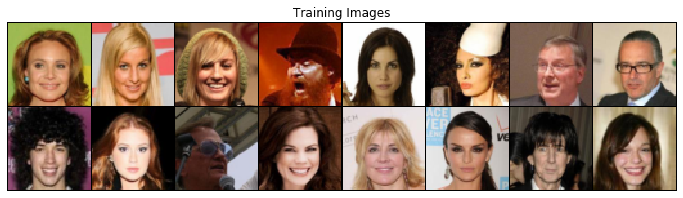

In [8]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# Define Image size
image_size = 64
# Select dataset
data_folder = './data/'

train_ds = dset.ImageFolder(root = data_folder,
                            transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                # Transform data from [0,1] scale to [-1,1] scale
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))
# Constuct dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
# Plot some training images
real_examples = next(iter(train_dl))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_examples[0][:16], padding=1, normalize=True),(1,2,0)))
plt.pause(0.001)

In [9]:
# Define loss function
loss_func = nn.BCELoss()
# Get initialized models and optimizers
model_G, model_D, opt_G, opt_D, epoch_start = get_dcgan(nz=100, ngf=64, ndf=64, device=device, lr=lr, betas=betas)
# Fit DCGAN
fit_dcgan(epochs, model_G, model_D, loss_func, opt_G, opt_D, train_dl, device, epoch_start)

Pretrained Model available, use it? [y/n]:y


### Test model

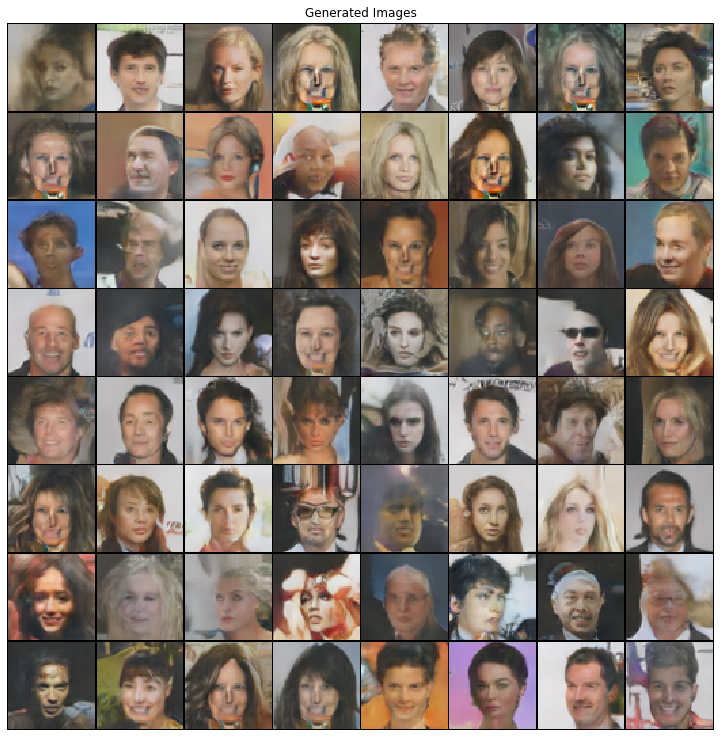

In [10]:
# Plot some training images
fakes = model_G(torch.randn(64,100,1,1,device=device)).detach().cpu()
plt.figure(figsize=(13,13))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fakes, padding=1, normalize=True),(1,2,0)))
plt.pause(0.001)